In [1]:
import torch
import time
import gc
import math
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from cnn.commons import full_inference_e2e, inc_inference_e2e,adaptive_drilldown
from cnn.vgg16 import VGG16
from cnn.vgg16_inc_v2 import IncrementalVGG16V2
from cnn.vgg16_inc_v1 import IncrementalVGG16V1

image_file_path = "../cnn/dog_resized.jpg"
interested_logit_index = 208

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# torch.cuda.synchronize()
prev_time = time.time()
outputs_full = full_inference_e2e(VGG16, image_file_path, 4, 4, interested_logit_index, batch_size=128)
torch.cuda.synchronize()
full_inference_time = time.time() - prev_time
print("Full Inference Time: " + str(full_inference_time))

../cnn/commons.py:108: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  orig_image = Variable(loader(orig_image).unsqueeze(0), volatile=True)


Full Inference Time: 12.0767159462


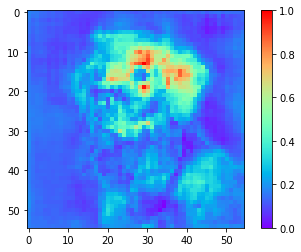

In [9]:
x = outputs_full
xmax, xmin = x.max(), x.min()
x = 1 - (x - xmin)/(xmax - xmin)

outputs_full_final = x
np.savetxt('temp', outputs_full_final)

plt.imshow(x, cmap=plt.cm.rainbow, interpolation='none')
plt.colorbar()

In [4]:
gc.collect()
torch.cuda.empty_cache()

In [5]:
def inc_inference(beta, patch_size=4, stride=1, adaptive=False):
    torch.cuda.synchronize()
    if not adaptive:
        outputs_inc = inc_inference_e2e(IncrementalVGG16V2, image_file_path, patch_size, stride, interested_logit_index,
                                  batch_size=128, beta=beta)
    else:
        outputs_inc = adaptive_drilldown(IncrementalVGG16V2, image_file_path, patch_size, stride, interested_logit_index,
                                    batch_size=128, beta=beta, percentile=20)
    
    torch.cuda.synchronize()
    x = outputs_inc
    
    #if beta != 1.0:
    #    x = ndimage.gaussian_filter(x, sigma=0.75*(0.5/beta)**2)

    xmax, xmin = x.max(), x.min()
    x = 1 - (x - xmin)/(xmax - xmin)
    return x

### Path growth thresholding

../cnn/vgg16_inc_v2.py:30: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.initial_result = full_model.forward_materialized(Variable(in_tensor, volatile=True)).cpu().data.numpy()


BETA: 1.0 Inference Time: 4.01001191139


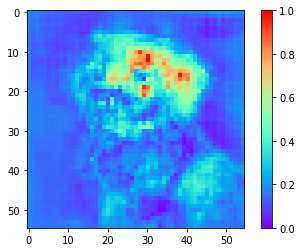

BETA: 0.9 Inference Time: 3.60279011726


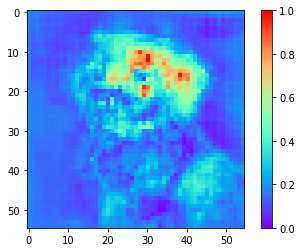

BETA: 0.8 Inference Time: 3.72374510765


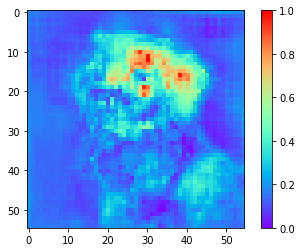

BETA: 0.7 Inference Time: 3.37202906609


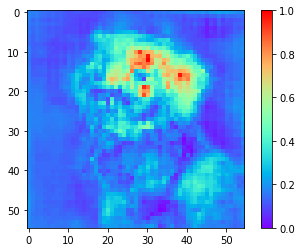

BETA: 0.6 Inference Time: 3.29982304573


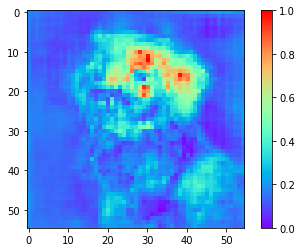

BETA: 0.5 Inference Time: 3.09757804871


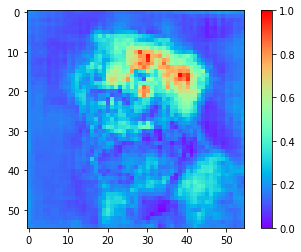

BETA: 0.4 Inference Time: 3.02934503555


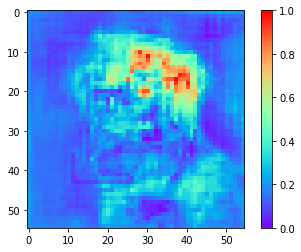

BETA: 0.3 Inference Time: 2.68550419807


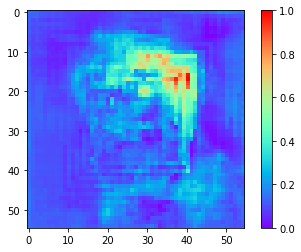

In [6]:
outputs_full_final = np.loadtxt('temp')
times = []
mse = []

for beta in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3]:
    prev_time = time.time()
    outputs_inc_final = inc_inference(beta, patch_size=4, stride=4)
    inc_inference_time = time.time()-prev_time
    times.append(inc_inference_time)
    mse.append(((outputs_inc_final - outputs_full_final) ** 2).mean(axis=None))
    
    plt.imshow(outputs_inc_final, cmap=plt.cm.rainbow, interpolation='none')
    plt.colorbar()
    label = "BETA: " + str(beta) +" Inference Time: " + str(inc_inference_time)
    print(label)
    plt.show()

Text(0,0.5,u'MSE')

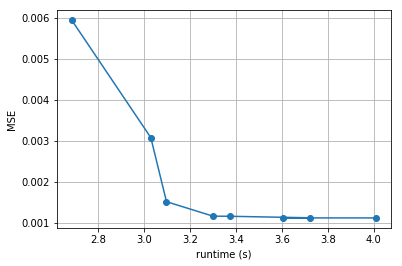

In [7]:
plt.plot(times, mse, marker='o')
plt.grid()
plt.xlabel('runtime (s)')
plt.ylabel('MSE')

### Adaptive drill-down

BETA: 1.0 Inference Time: 12.6585690975


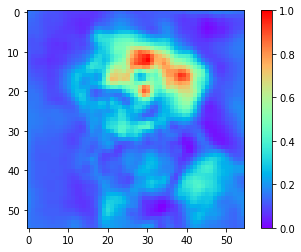

BETA: 0.9 Inference Time: 12.7233128548


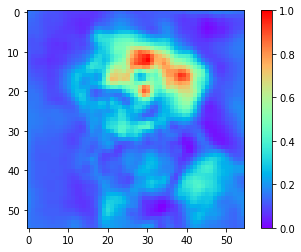

BETA: 0.8 Inference Time: 12.708687067


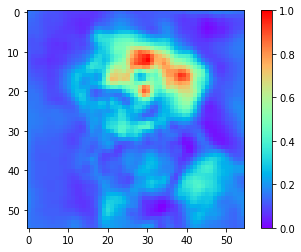

BETA: 0.7 Inference Time: 12.1133079529


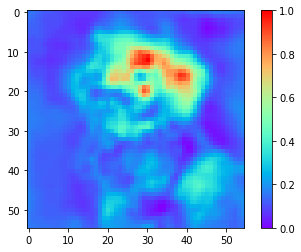

BETA: 0.6 Inference Time: 11.7865650654


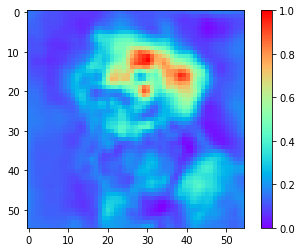

BETA: 0.5 Inference Time: 10.8971500397


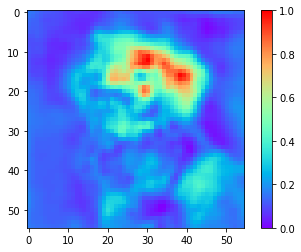

BETA: 0.4 Inference Time: 10.2498989105


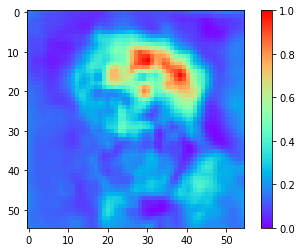

BETA: 0.3 Inference Time: 8.80248308182


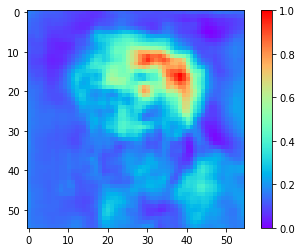

Text(0,0.5,u'MSE')

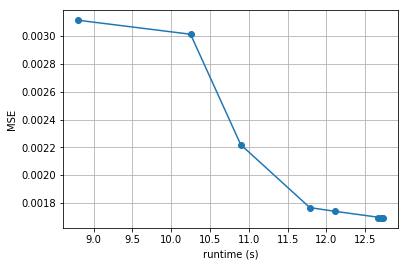

In [10]:
outputs_full_final = np.loadtxt('temp')
times = []
mse = []

for beta in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3]:
    prev_time = time.time()
    outputs_inc_final = inc_inference(beta, patch_size=4, stride=4, adaptive=True)
    inc_inference_time = time.time()-prev_time
    times.append(inc_inference_time)
    mse.append(((outputs_inc_final - outputs_full_final) ** 2).mean(axis=None))
    
    plt.imshow(outputs_inc_final, cmap=plt.cm.rainbow, interpolation='none')
    plt.colorbar()
    label = "BETA: " + str(beta) +" Inference Time: " + str(inc_inference_time)
    print(label)
    plt.show()
    
plt.plot(times, mse, marker='o')
plt.grid()
plt.xlabel('runtime (s)')
plt.ylabel('MSE')

In [ ]:
outputs_full_final = np.loadtxt('temp')
temp = np.abs(np.around(outputs_full_final, decimals=3) - np.around(outputs_inc_final, decimals=3))

In [ ]:
plt.imshow(temp, cmap=plt.cm.rainbow, interpolation='none')
plt.colorbar()